In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from scipy import stats
import itertools
import warnings
from sklearn import linear_model
from sklearn.decomposition import FastICA
from sklearn.mixture import GaussianMixture
import graphviz
import lingam
from lingam.utils import make_dot
import cdt
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
os.environ["PATH"] += os.pathsep + 'C:\\Utility\\CompUtils\\Graphviz\\bin'

In [16]:
# Import demographics
demographics_url = f'https://raw.githubusercontent.com/vbtCogSci/features_of_agency/master/data/datasets/properties_1/datasets_csv/demographics.csv'
df_demo = pd.read_csv(demographics_url, sep=',').rename({'Unnamed: 0': 'part_id'}, axis=1)

# Import sanity checks
sanity_checks_url = f'https://raw.githubusercontent.com/vbtCogSci/features_of_agency/master/data/datasets/properties_1/datasets_csv/sanity_checks.csv'
sanity_checks_in = pd.read_csv(sanity_checks_url, sep=',').drop('Unnamed: 0', axis=1)

# Task data
df_task = f'https://raw.githubusercontent.com/vbtCogSci/features_of_agency/master/data/datasets/properties_1/datasets_csv/task_data.csv'
df_task = pd.read_csv(df_task).drop('Unnamed: 0', axis=1)

In [17]:
properties = df_task.columns[4:-4].to_list()
properties_agency = df_task.columns[4:-3].to_list()
properties_full = df_task.columns[4:].to_list()

X = df_task[properties_agency].to_numpy().T 
U_label = properties_agency

print(properties)
print(properties_agency)
print(properties_full)
df_task.columns

['movement', 'energy', 'replication', 'complexity', 'learning', 'reaction', 'mistakes', 'communication', 'variety', 'monitoring']
['movement', 'energy', 'replication', 'complexity', 'learning', 'reaction', 'mistakes', 'communication', 'variety', 'monitoring', 'agency']
['movement', 'energy', 'replication', 'complexity', 'learning', 'reaction', 'mistakes', 'communication', 'variety', 'monitoring', 'agency', 'goal_setting', 'goal_directedness', 'freewill']


Index(['part_id', 'word', 'reaction_time', 'slider_order', 'movement',
       'energy', 'replication', 'complexity', 'learning', 'reaction',
       'mistakes', 'communication', 'variety', 'monitoring', 'agency',
       'goal_setting', 'goal_directedness', 'freewill'],
      dtype='object')

In [18]:
df_task.groupby('word').mean().loc[['car', 'robot_vacuum_cleaner', 'thermostat', 'wristwatch'] + ['hammer', 'rock']]
#df_task.groupby('word').mean().loc[]

,part_id,reaction_time,slider_order,movement,energy,replication,complexity,learning,reaction,mistakes,communication,variety,monitoring,agency,goal_setting,goal_directedness,freewill
word,,,,,,,,,,,,,,,,,
car,6503117.5,42711.590,2.5,35.50,90.55,3.60,85.40,7.45,32.55,45.95,15.95,29.60,14.95,12.15,5.65,21.50,1.25
robot_vacuum_cleaner,6503117.5,53180.590,2.5,65.30,82.40,1.65,73.05,32.45,46.40,48.15,24.85,28.80,30.25,19.10,12.25,33.70,3.00
thermostat,6503117.5,49085.760,2.5,8.95,71.30,2.90,45.90,4.15,39.75,30.15,13.20,9.70,13.00,12.15,8.90,21.95,1.15
wristwatch,6503117.5,95319.745,2.5,16.15,72.10,1.05,65.35,6.50,19.35,35.90,18.80,23.80,13.90,15.50,6.90,10.15,3.50
hammer,6503117.5,38366.295,2.5,0.95,37.70,1.10,9.40,1.90,11.55,12.40,1.25,26.55,1.35,10.70,1.60,17.65,1.35
rock,6503117.5,72264.715,2.5,5.30,12.45,5.45,20.15,1.00,35.00,1.00,1.95,14.30,0.95,2.10,0.80,1.05,15.05


In [19]:
df_task[properties_full]

,movement,energy,replication,complexity,learning,reaction,mistakes,communication,variety,monitoring,agency,goal_setting,goal_directedness,freewill
0,63.0,88.0,15.0,88.0,69.0,64.0,88.0,78.0,79.0,46.0,13.0,46.0,48.0,56.0
1,2.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,85.0,11.0,72.0,5.0,65.0,71.0,68.0,79.0,89.0,1.0,81.0,58.0,4.0
3,0.0,93.0,1.0,80.0,1.0,62.0,39.0,13.0,83.0,4.0,1.0,3.0,3.0,2.0
4,54.0,89.0,2.0,87.0,0.0,2.0,44.0,1.0,74.0,3.0,3.0,1.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.0,100.0,0.0,93.0,53.0,50.0,100.0,0.0,100.0,88.0,0.0,67.0,100.0,0.0
396,0.0,100.0,0.0,88.0,53.0,63.0,100.0,50.0,100.0,100.0,0.0,54.0,100.0,0.0
397,0.0,76.0,0.0,0.0,0.0,0.0,100.0,0.0,82.0,0.0,0.0,0.0,100.0,0.0
398,0.0,79.0,0.0,73.0,23.0,100.0,92.0,0.0,23.0,76.0,0.0,22.0,100.0,0.0


<AxesSubplot:xlabel='goal_setting', ylabel='Count'>

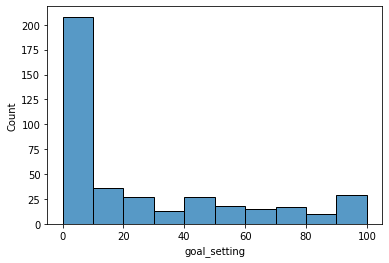

In [20]:
sns.histplot(df_task.goal_setting)

## Causal discovery using DirectLINGAM (Shimizu et al., 2011)

Index(['part_id', 'word', 'reaction_time', 'slider_order', 'movement',
       'energy', 'replication', 'complexity', 'learning', 'reaction',
       'mistakes', 'communication', 'variety', 'monitoring', 'agency',
       'goal_setting', 'goal_directedness', 'freewill'],
      dtype='object')
[1, 2, 6, 9, 3, 10, 5, 11, 4, 7, 0, 12, 8, 13]
[[0.   0.   0.   0.14 0.   0.   0.03 0.   0.06 0.   0.   0.   0.01 0.  ]
 [0.   0.   0.   0.04 0.02 0.18 0.   0.   0.   0.   0.   0.   0.   0.07]
 [0.   0.   0.   0.07 0.03 0.04 0.09 0.11 0.   0.1  0.   0.   0.   0.  ]
 [0.14 0.04 0.07 0.   0.04 0.35 0.   0.01 0.   0.   0.   0.02 0.02 0.05]
 [0.   0.02 0.03 0.04 0.   0.   0.03 0.   0.   0.   0.   0.   0.15 0.  ]
 [0.   0.18 0.04 0.35 0.   0.   0.3  0.   0.   0.   0.02 0.   0.   0.  ]
 [0.03 0.   0.09 0.   0.03 0.3  0.   0.   0.   0.   0.   0.   0.   0.01]
 [0.   0.   0.11 0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.06 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0. 

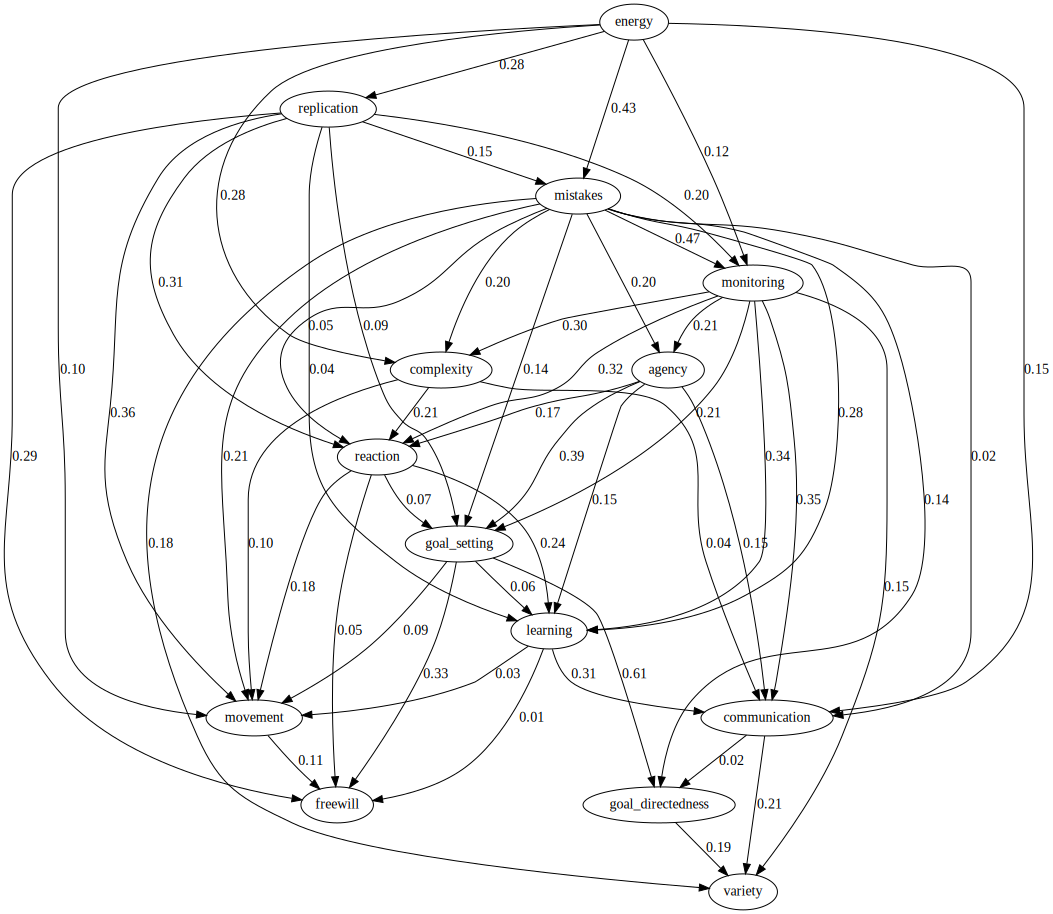

In [40]:
df = df_task
print(df.columns)
df = df_task.loc[np.random.choice(df_task.index, 200)]
X = df[properties_full].to_numpy().T 
U_label = properties_full

model = lingam.ICALiNGAM()
model.fit(X.T)

print(model.causal_order_)

p_values = model.get_error_independence_p_values(X.T)
print(np.round(p_values, 2))

cleaner_matrix = np.zeros(model.adjacency_matrix_.shape)
mask = model.adjacency_matrix_ > 1e-2
cleaner_matrix[mask] = model.adjacency_matrix_[mask]
make_dot(cleaner_matrix, labels=U_label)

Index(['part_id', 'word', 'reaction_time', 'slider_order', 'movement',
       'energy', 'replication', 'complexity', 'learning', 'reaction',
       'mistakes', 'communication', 'variety', 'monitoring', 'agency',
       'goal_setting', 'goal_directedness', 'freewill'],
      dtype='object')
[13, 2, 10, 1, 11, 12, 0, 3, 7, 4, 9, 8, 5, 6]
[[0.   0.   0.   0.   0.   0.   0.04 0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.01 0.08 0.   0.   0.02 0.   0.02 0.   0.   0.   0.  ]
 [0.   0.   0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.08 0.   0.   0.   0.   0.   0.06 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.04 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.02 0.   0.   0.   0.   0.   0.   0.   0.01 0.   0.   0.15]
 [0.   0.   0.   0.   0.06 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0. 

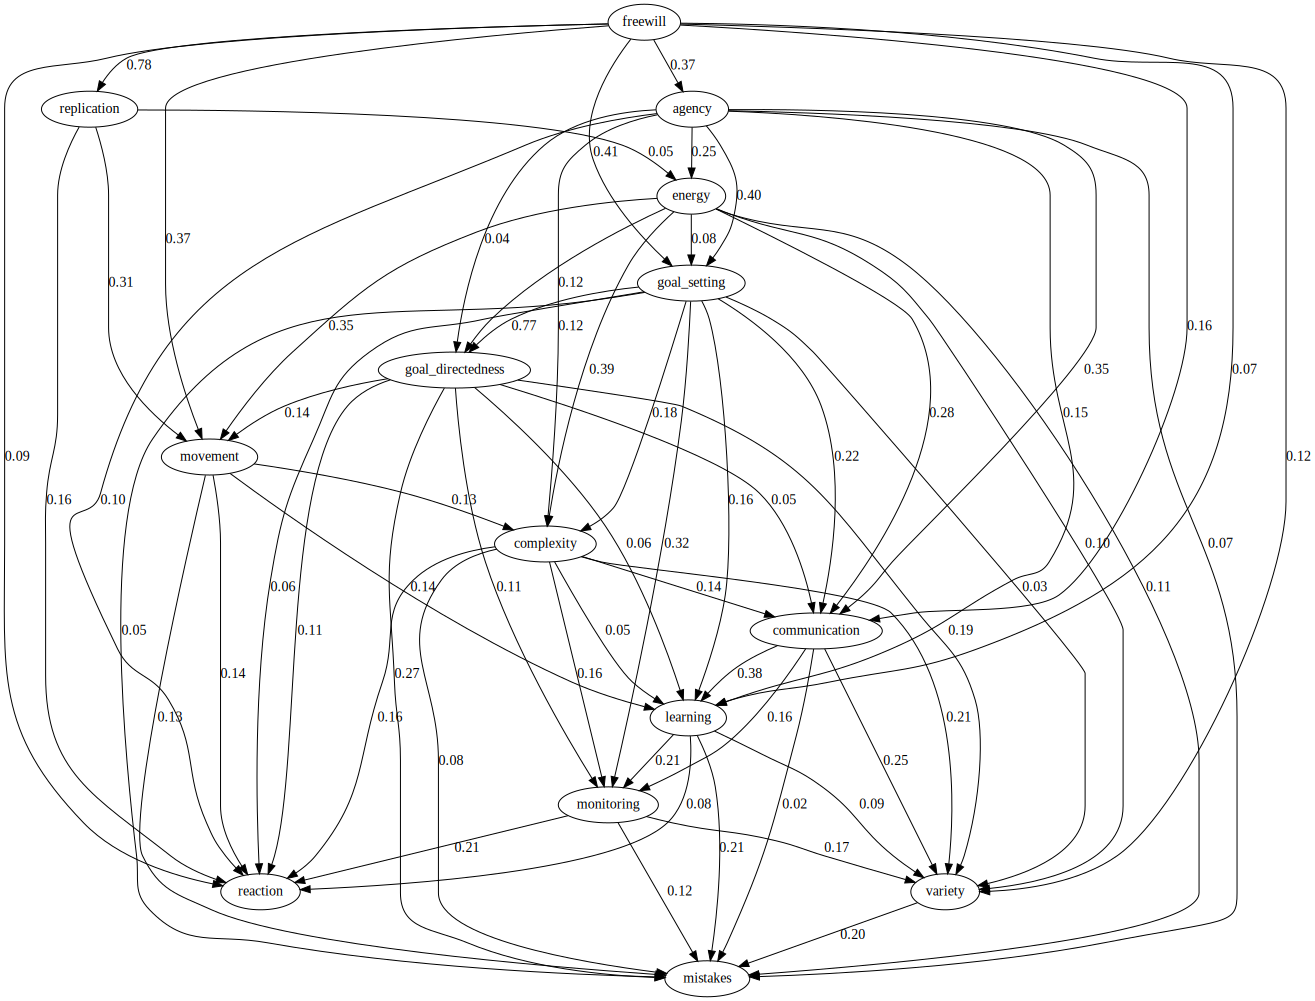

In [37]:
words = ['chimpanzee']
#df = df_task[df_task.word.isin(words)]
df = df_task[df_task.word.isin(words)]
df = df_task.loc[np.random.choice(df_task.index, 400)]
print(df.columns)
X = df[properties_full].to_numpy().T 
U_label = properties_full

model = lingam.DirectLiNGAM()
model.fit(X.T)

print(model.causal_order_)

p_values = model.get_error_independence_p_values(X.T)
print(np.round(p_values, 2))

cleaner_matrix = np.zeros(model.adjacency_matrix_.shape)
mask = model.adjacency_matrix_ > 1e-2
cleaner_matrix[mask] = model.adjacency_matrix_[mask]
make_dot(cleaner_matrix, labels=U_label)

In [24]:
df = df_task
#print(df.columns)
X = df[properties_agency].to_numpy().T 
U_label = properties_agency

model = lingam.VARMALiNGAM()
model.fit(X.T)

print(model.causal_order_)

p_values = model.get_error_independence_p_values()
print(np.round(p_values, 2))

adj = model.adjacency_matrices_[0][0, :, :]
cleaner_matrix = np.zeros(adj.shape)
mask = adj > 1.5e-1
cleaner_matrix[mask] = adj[mask]
make_dot(cleaner_matrix, labels=U_label)

KeyboardInterrupt: 

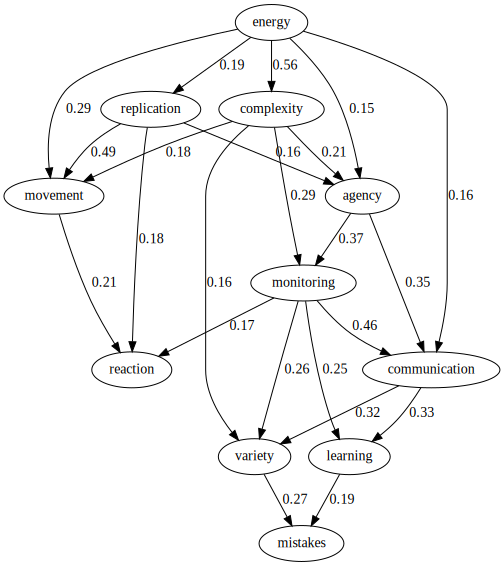

In [ ]:
adj = model.adjacency_matrices_[0][0, :, :]
cleaner_matrix = np.zeros(adj.shape)
mask = adj > 1.5e-1
cleaner_matrix[mask] = adj[mask]
make_dot(cleaner_matrix, labels=U_label)

In [ ]:

df_task['mean_score'] = df_task[properties].mean(axis=1)
df_means = df_task[['word'] + properties].groupby('word').mean()#.sort_values('agency')
df_means

,movement,energy,replication,complexity,learning,reaction,mistakes,communication,variety,monitoring
word,,,,,,,,,,
artificial_intelligence,31.05,73.75,28.00,76.10,69.45,60.90,77.15,66.55,75.40,64.45
autonomous_car,70.90,90.35,1.70,91.10,42.30,55.80,71.70,37.60,54.05,40.95
biological_virus,69.30,67.10,89.45,51.75,34.00,68.80,27.75,12.05,34.60,23.55
car,35.50,90.55,3.60,85.40,7.45,32.55,45.95,15.95,29.60,14.95
chicken,97.10,87.95,90.75,78.95,54.75,77.55,65.85,54.20,58.30,40.40
chimpanzee,95.15,92.20,84.40,88.75,81.05,88.30,87.50,79.90,81.00,62.95
computer,1.20,94.10,4.35,90.00,48.30,33.35,60.30,43.55,84.45,45.55
computer_virus,28.75,56.80,76.65,53.00,29.15,43.25,31.80,24.30,35.40,27.35
dolphin,96.45,94.40,84.80,86.45,81.55,87.00,80.45,82.35,74.05,64.95


In [ ]:
X = df_means.to_numpy()
labels = df_means.index.to_list()


In [ ]:
n_components = np.arange(3, 20)
covariances = ['full', 'diag']

num_samples = 15

model_selection = pd.DataFrame(columns=['n_comp', 'cov', 'bic'])
for c in n_components:
    for cov in covariances:
        for i in range(num_samples):
            gm = GaussianMixture(n_components=c, covariance_type=cov).fit(X)
            model_selection.loc[model_selection.index.size] = [c, cov, gm.bic(X)]

KeyboardInterrupt: ignored

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

sns.barplot(x='n_comp', y='bic', hue='cov', data=model_selection, ax=ax)

plt.show()

In [ ]:
num_components = 20
cov = 'full'

gm = GaussianMixture(n_components=num_components, covariance_type=cov).fit(X)

print(f'BIC: {gm.bic(X)}')
print(np.round(gm.weights_, 4))
print()
print(np.round(gm.means_, 4))
print()

for i in range(gm.covariances_.shape[0]):
    print(np.round(np.diag(gm.covariances_[i, :, :])**(1/2), 4))

plt.hist(gm.predict_proba(X).max(axis=1))
plt.show()

In [ ]:
a = gm.predict(X)

df_means['assignment'] = a

df_means.sort_values('assignment')

In [ ]:
sns.histplot(df_task[df_task.word == 'computer_virus'].agency)

In [ ]:
sns.histplot(df_task.agency)

In [ ]:
pids = df_demo.part_id.to_list()

for i, pid in enumerate(pids):
    df_pid = df_task.loc[df_task.part_id == pid].sort_values('mean_score')
    lower_scores = df_pid.loc[df_pid.index[:2]].word.to_list()
    #if not ('rock' in lower_scores and 'hammer' in lower_scores):
    if not ('rock' in lower_scores):
        remove = np.ones(df_pid.shape[0])
    else:
        remove = np.zeros(df_pid.shape[0])

    df_task.loc[df_pid.index, 'exclude'] = remove

In [ ]:
df_task[df_task.exclude == 0]